In [59]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
import pytorch_lightning as pl
from typing import Tuple
import PIL
from PIL import Image
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import csv
from torchmetrics.functional import accuracy
import numpy as np
import torchvision
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
from torchvision import datasets

In [60]:
# Fixing random state for reproducibility using NumPy
rng = np.random.RandomState(31)

# Setting the seed for NumPy to ensure reproducibility
np.random.seed(31)

# Setting the seed for PyTorch Lightning to ensure reproducibility
pl.seed_everything(31)

31

In [61]:
dataset0=datasets.ImageFolder(root="/kaggle/input/hw2-train/train",transform=None)

class_names=dataset0.classes
print(class_names)
print(len(class_names))

['0', '1', '2', '3', '4']
5


In [62]:
class HW2_DataModule(pl.LightningDataModule): 
    def __init__(self, train_data_dir, test_data_dir, batch_size, num_workers=4, val_split=0.2):
        super(HW2_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.test_data_dir = test_data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split

        # Initialize the custom image transformation
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        # Load train and validation datasets
        dataset = ImageFolder(self.train_data_dir, transform=self.transform)

        # Split the dataset into training and validation sets
        train_size = int((1.0 - self.val_split) * len(dataset))
        val_size = len(dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

        # Load the test dataset with preprocessing
        self.test_dataset = ImageFolder(self.test_data_dir, transform=self.transform)

    def train_dataloader(self):
        # Return the DataLoader for the training dataset
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        # Return the DataLoader for the validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        # Return the DataLoader for the test dataset
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    

In [63]:
class HW2_Model(pl.LightningModule):
    def __init__(self, input_channels, num_classes):
        super(HW2_Model, self).__init__()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(input_channels, 6, 3, 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7744, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.conv1(x)))

        x = self.maxpool2(self.relu(self.conv2(x)))
            
        x = self.relu(self.fc1(self.flatten(x)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return self.log_softmax(x)
    
    def display_images_labels_predictions(self, images, labels, predictions):
        # Convert images to PIL format for visualization
        to_pil = ToPILImage()
        pil_images = [to_pil(image) for image in images]

        # Display images, labels, and predictions
        for i in range(len(images)):
            plt.imshow(pil_images[i])
            plt.title(f"Label: {labels[i].item()}, Prediction: {predictions[i].item()}")
            plt.show()
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        
        # Display images, labels, and predictions for the first 6 samples
        if batch_idx == 0:
            x, y = val_batch
            y_hat = self(x)
            loss = nn.CrossEntropyLoss()(y_hat, y)

            # Calculate accuracy manually
            preds = torch.argmax(y_hat, dim=1)
            self.display_images_labels_predictions(x[:6], y[:6], preds[:6])
        
        return metrics

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        # Display images, labels, and predictions for the first 6 samples
        if batch_idx == 0:
            x, y = test_batch
            y_hat = self(x)
            loss = nn.CrossEntropyLoss()(y_hat, y)

            # Calculate accuracy manually
            preds = torch.argmax(y_hat, dim=1)
            self.display_images_labels_predictions(x[:6], y[:6], preds[:6])
        
        return metrics

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    

# Function to calculate metrics at the end of an epoch.
    def _epoch_end(self, stage, outputs):
        
        # Combine predictions and labels from all batches in the epoch.
        predictions = torch.hstack([o["preds"] for o in outputs])
        labels = torch.vstack([o["labels"] for o in outputs]).argmax(axis=1)
        total = len(labels)
        
        # Calculate accuracy and error rate.
        accuracy = sum(predictions == labels).item() / total * 100
        error_rate = sum(predictions != labels).item() / total * 100
        
        # Log accuracy and error rate for monitoring.
        self.log_dict({f"accuracy/{stage}": accuracy, 
                       f"error_rate/{stage}": error_rate}, prog_bar=True)

In [64]:
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)
# tb_logger = TensorBoardLogger("logs/", log_graph=True, log_images=True, log_histograms=True)


In [65]:
# Initialize the model and data module
model = HW2_Model(input_channels=3, num_classes=5)
datamodule = HW2_DataModule(train_data_dir="/kaggle/input/hw2-train/train", test_data_dir="/kaggle/input/hw2-test/test", batch_size=64)

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=5,
    logger=pl.loggers.TensorBoardLogger("logs/"),
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

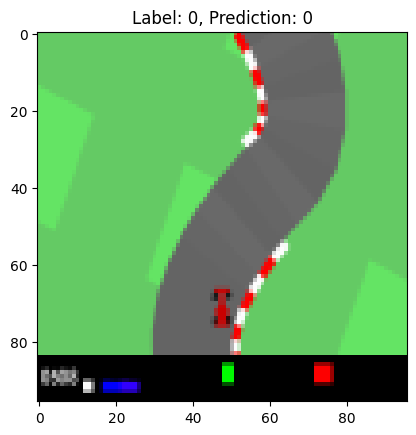

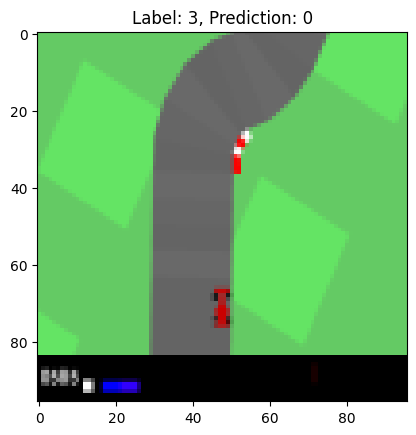

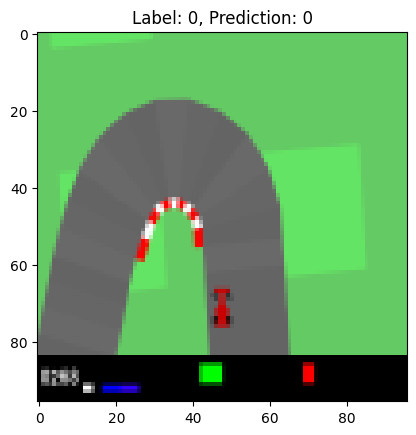

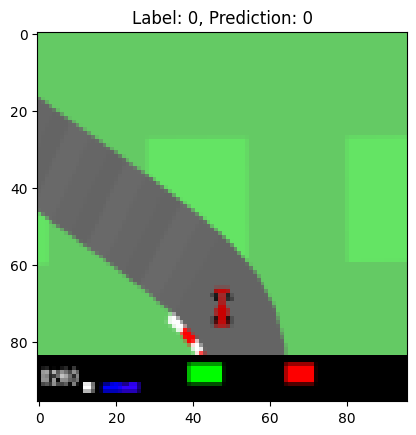

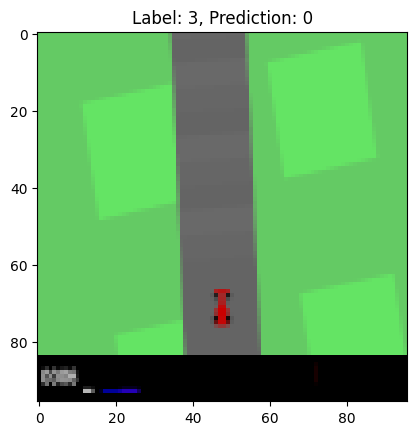

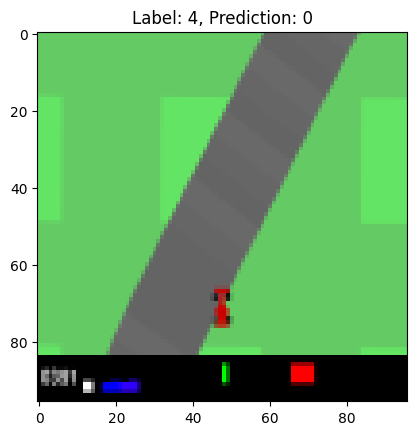

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

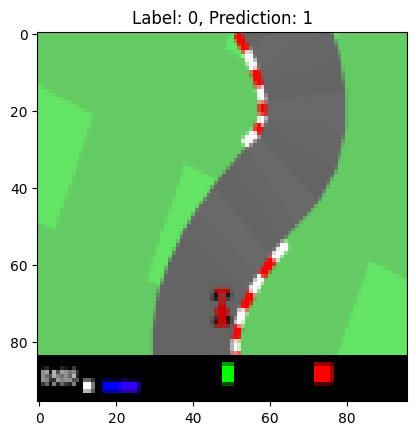

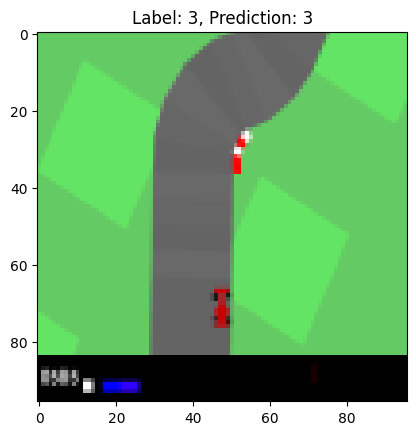

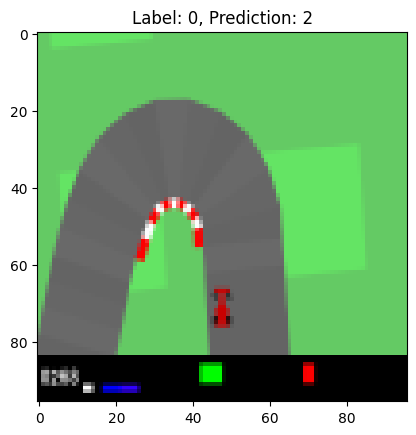

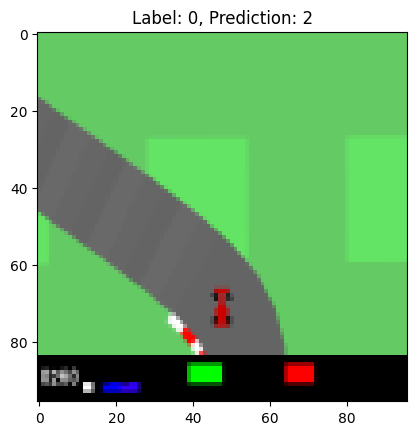

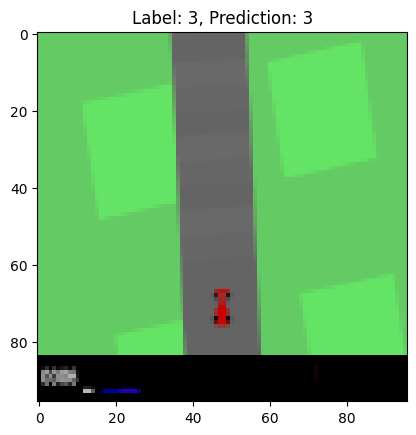

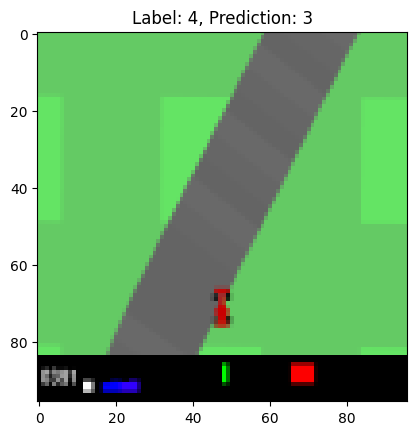

Validation: |          | 0/? [00:00<?, ?it/s]

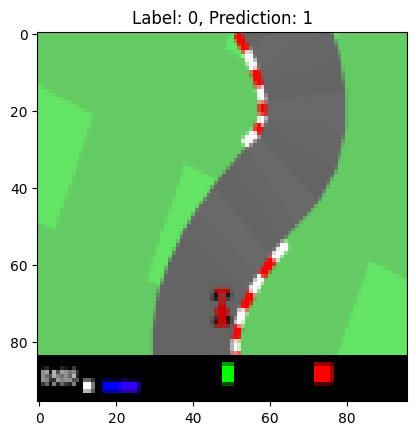

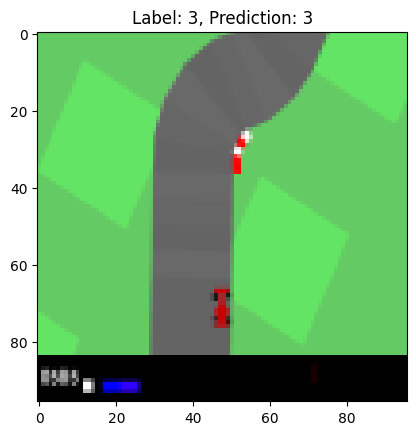

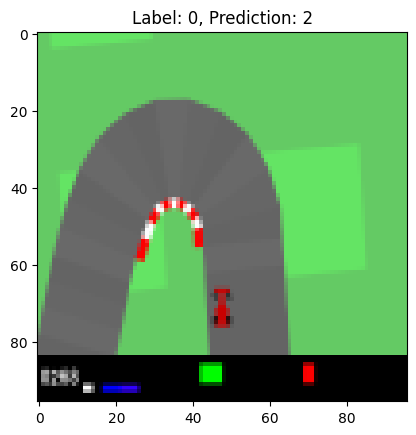

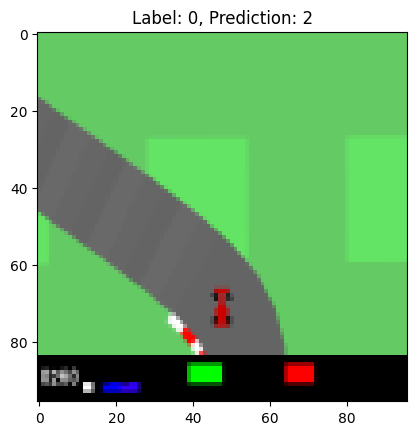

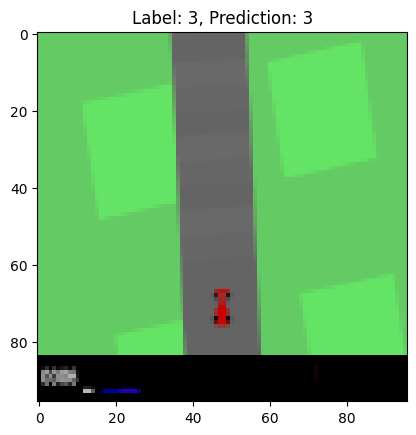

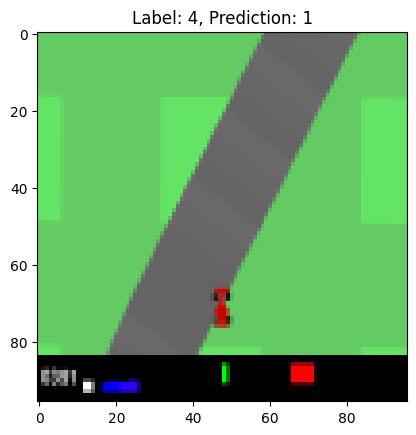

Validation: |          | 0/? [00:00<?, ?it/s]

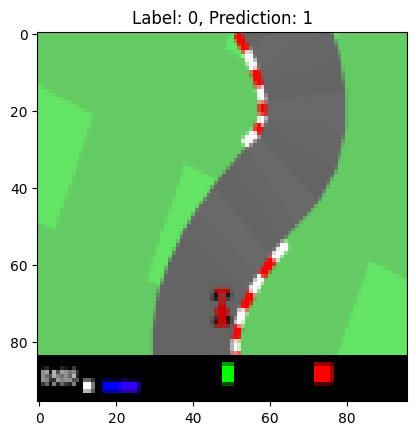

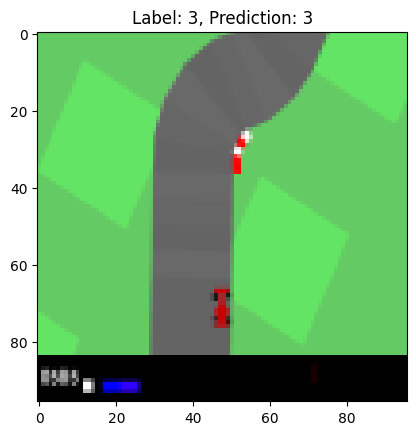

In [ ]:
# Train the model
trainer.fit(model, datamodule)

In [ ]:
# Test the trained model using the testing data from the DataModule.
result = trainer.test(model, datamodule)

In [ ]:
# Access the test loss and accuracy from the result dictionary
test_loss = result[0]['test_loss']
test_accuracy = result[0]['test_acc']

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)